# Deep Learning
## Conditional Variational Autoencoders for Human Face Generation

Firstly, we will investigate the improvement in reconstruction quality gained by allowing the VAE to view the ground truth gender, ethnicity and age labels. This is a conditional variational autoencoder.

In [1]:
!pip install pyarrow


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfpl = tfp.layers

### Dataset

In [ ]:
data = pd.read_parquet("data.parquet")[['pixels','age','gender','ethnicity']]

# parse pixels datatype, resize and rescale
def preprocess_pixel_data(pixel_string: str) -> np.ndarray:
    return np.squeeze(np.array(pixel_string.split(' '), dtype="float32").reshape(48, 48, 1)/255., axis=-1)

data.pixels = data.pixels.apply(preprocess_pixel_data)

In [ ]:
# plot of one observation per gender-ethnicity class.
f, axs = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)

for gender in sorted(data.gender.unique()):
    for ethnicity in sorted(data.ethnicity.unique()):
        person = data.query('age>16').query('age<45')\
                     .query(f'gender=={gender}')\
                     .query(f'ethnicity=={ethnicity}')\
                     .sample()
        axs[gender,ethnicity].imshow(person.pixels.values[0], cmap = 'Greys_r')
        axs[gender,ethnicity].set_title(f"Age={person.age.values},\nGender={gender},\nEthnicity={ethnicity}")
        axs[gender,ethnicity].axis('off')

plt.show()

In [ ]:
# we one-hot encode the ethnicity class variable. 
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_features = one_hot_encoder.fit_transform(data.ethnicity.values.reshape(-1,1))

ethnicities = ['caucasian','black','east_asian','south_asian','latino']

data[ethnicities] = encoded_features
data = data.drop('ethnicity', axis=1)

#### Creating the Tensorflow dataset objects

In [1]:
# firstly, splitting data 80/10/10 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=2023)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=2023)


# arranging the data to be suitable for VAE model training 
def inputs_and_outputs(image,label):
    return (image,label), image

# function to convert a pandas DataFrame into a TensorFlow dataset
def df_to_tf_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe[['age', 'gender'] + ethnicities]
    images = np.stack(dataframe['pixels'].to_numpy())
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(inputs_and_outputs)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# converting from DataFrames to TensorFlow datasets
train_ds = df_to_tf_dataset(train_data)
val_ds = df_to_tf_dataset(val_data, shuffle=False)
test_ds = df_to_tf_dataset(test_data, shuffle=False)

NameError: name 'train_test_split' is not defined

In [ ]:
def retrieve_ethnicity_label(encoded_label: np.ndarray):
    return ethnicities[one_hot_encoder.inverse_transform(encoded_label.numpy().reshape(1,-1))[0][0]]

In [ ]:
# quick check the datasets were processed properly
for (peek_images, peek_labels), _ in train_ds.take(3):
    peek_image = peek_images[0]
    peek_label = peek_labels[0]
    plt.figure(figsize=(2,2))
    plt.imshow(peek_image, cmap='Greys_r')
    plt.title(f"Age={peek_label[0]}, Gender={peek_label[1]},\n"+
              f"Ethnicity={retrieve_ethnicity_label(peek_label[2:])}")
    plt.axis('off')
    plt.show()

### Model

In [46]:
# building the Model using the Keras functional API
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Reshape

np.random.seed(42)
tf.random.set_seed(42)

# define the number of latent variables
latent_dim = 128

prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim]))

In [47]:
class ScaledKLDivergenceLayer(tf.keras.layers.Layer):
    """ 
    Custom layer to compute the Kullback-Leibler divergence loss with a scaling factor.
    The true integral in the KLD is intractible, so we approximate with Monte carlo.
    """

    def __init__(self, 
                 prior, 
                 scale_factor=1.0, 
                 monte_carlo_samples=1, 
                 **kwargs):
        super(ScaledKLDivergenceLayer, self).__init__(**kwargs)
        self.prior = prior
        self.scale_factor = scale_factor
        self.test_points_fn = lambda d: d.sample(monte_carlo_samples)

    def call(self, inputs, training=None):
        return self.scale_factor * tfp.layers.KLDivergenceAddLoss(
            self.prior,
            use_exact_kl=False,
            test_points_fn = self.test_points_fn)(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "prior": self.prior,
            "scale_factor": self.scale_factor,
            "use_exact_kl": self.use_exact_kl,
            "test_points_fn": self.test_points_fn
        })
        return config


In [48]:
# building the Encoder Model using the Keras functional API
image_input = Input(shape=(48,48,1), name='image')
label_input = Input(shape=(7,), name='label')

# convolutional layers
h = Conv2D(32, (2, 2), activation='relu', padding='same')(image_input)
h = MaxPooling2D((2, 2), padding='same')(h)
h = Conv2D(64, (2, 2), activation='relu', padding='same')(h)
h = MaxPooling2D((2, 2), padding='same')(h)
h = Conv2D(128, (2, 2), activation='relu', padding='same')(h)
h = MaxPooling2D((2, 2), padding='same')(h)
h = Conv2D(256, (2, 2), activation='relu', padding='same')(h)
h = MaxPooling2D((2, 2), padding='same')(h)

# dense layers, now includes class and age labels
h = Flatten()(h)
h = Concatenate()([h, label_input])
h = Dense(latent_dim*16, activation='relu')(h)
h = Dense(latent_dim*4, activation='relu')(h)

# next we formulate the approximate posterior.
# recall that TriL matrix represents Cholesky Decomposition of full Covariance Matrix
h = Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim))(h)
h = tfpl.MultivariateNormalTriL(latent_dim)(h)

# KL Divergence term with a scaling factor to reduce regularisation
z = ScaledKLDivergenceLayer(prior, scale_factor=0.01, monte_carlo_samples=10)(h)

encoder = Model(inputs = [image_input, label_input], outputs = z, name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 48, 48, 32)   160         ['image[0][0]']                  
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 24, 24, 32)  0           ['conv2d_20[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 24, 24, 64)   8256        ['max_pooling2d_20[0][0]'] 

In [49]:
z_input = Input(shape=(latent_dim,), name='z')

# combine the latent vector and the label input
h = Concatenate()([z_input, label_input])

# Dense layers
h = Dense(latent_dim*4, activation='relu')(h)
h = Dense(latent_dim*16, activation='relu')(h)
h = Dense(3*3*256, activation='relu')(h) 
h = Reshape((48,48))(h)

outputs = h

decoder = Model(inputs=[z_input, label_input], outputs=outputs, name='decoder')

decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z (InputLayer)                 [(None, 128)]        0           []                               
                                                                                                  
 label (InputLayer)             [(None, 7)]          0           []                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 135)          0           ['z[0][0]',                      
                                                                  'label[0][0]']                  
                                                                                                  
 dense_27 (Dense)               (None, 512)          69632       ['concatenate_9[0][0]']    

In [50]:
cvae = Model(inputs = encoder.inputs, outputs = decoder([encoder.output, label_input]))

cvae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 48, 48, 32)   160         ['image[0][0]']                  
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 24, 24, 32)  0           ['conv2d_20[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 24, 24, 64)   8256        ['max_pooling2d_20[0][0]'] 

In [51]:
# defining loss function and metrics

def reconstruction_loss(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred) 
    #recall that MSE is equivalent to logprob for Gaussian density

# peak signal to noise ratio
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [52]:
# model training

learning_rate = 0.001  # Set your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

cvae.compile(optimizer=optimizer, loss=reconstruction_loss, metrics=[psnr_metric])

cvae.fit(train_ds, 
         validation_data = val_ds, 
         epochs=50,
         callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)])

Epoch 1/50
593/593 [==============================] - 8s 10ms/step - loss: 0.0625 - psnr_metric: 12.3487 - val_loss: 0.0420 - val_psnr_metric: 13.7603
Epoch 2/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0379 - psnr_metric: 14.2424 - val_loss: 0.0302 - val_psnr_metric: 15.1953
Epoch 3/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0266 - psnr_metric: 15.7756 - val_loss: 0.0242 - val_psnr_metric: 16.1678
Epoch 4/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0238 - psnr_metric: 16.2496 - val_loss: 0.0228 - val_psnr_metric: 16.4189
Epoch 5/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0221 - psnr_metric: 16.5674 - val_loss: 0.0219 - val_psnr_metric: 16.6015
Epoch 6/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0214 - psnr_metric: 16.7170 - val_loss: 0.0214 - val_psnr_metric: 16.7009
Epoch 7/50
593/593 [==============================] - 5s 9ms/step - loss: 0.0209 - psnr_metric: 16.

### Test set evaluation

1/1 [==============================] - 0s 37ms/step


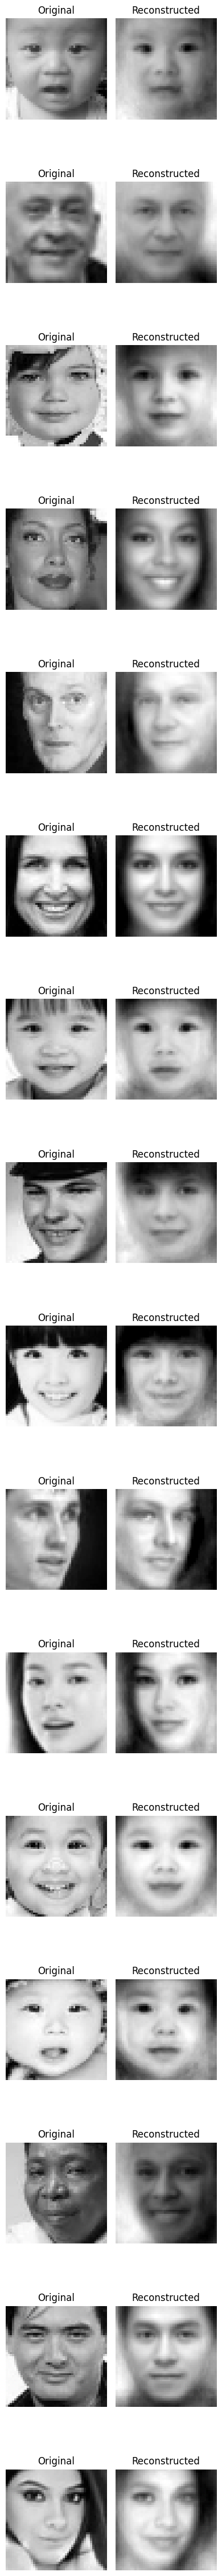

In [53]:
# Generate a few test data examples
num_examples = 16
test_samples = test_ds.take(num_examples)

# obtain the original images and their VAE reconstructions
original_images = []
reconstructed_images = []

for (image,label),_ in test_samples:
    original_images.append(image[0].numpy())  # Extract the first image from each batch
    reconstructed_image = cvae.predict([image, label])[0]  # Generate reconstruction using cvae model
    reconstructed_images.append(reconstructed_image)
    
# plot original images vs VAE reconstructions
fig, axes = plt.subplots(nrows=num_examples, ncols=2, figsize=(4, num_examples*4))

for i in range(num_examples):
    axes[i, 0].imshow(original_images[i], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(reconstructed_images[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')

plt.subplots_adjust(wspace=0, hspace=-0.9)
plt.tight_layout()
plt.show()

In [54]:
cvae.evaluate(test_ds)

75/75 [==============================] - 0s 3ms/step - loss: 0.0138 - psnr_metric: 18.6453


[0.013789153657853603, 18.64529037475586]